# 在 Google Colab 上使用 DeepSeek-OCR

此笔记本用于搭建并运行 DeepSeek-OCR 光学字符识别模型。

**环境要求：**
- GPU 运行时（推荐 T4 或更高）
- 约 15-20 分钟的安装时间

**项目来源：** https://github.com/deepseek-ai/DeepSeek-OCR

In [1]:
#加载谷歌硬盘，用于永久保存文件
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 环境配置与 GPU 检查

In [2]:
# 检查 GPU 是否可用
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Mon Oct 27 13:13:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. 克隆仓库

In [3]:
# 克隆 DeepSeek-OCR 仓库
!git clone https://github.com/deepseek-ai/DeepSeek-OCR.git /content/DeepSeek-OCR
%cd /content/DeepSeek-OCR

fatal: destination path '/content/DeepSeek-OCR' already exists and is not an empty directory.
/content/DeepSeek-OCR


## 3. 安装依赖

安装 PyTorch、Transformers 及其他所需包。

In [4]:
# 安装支持 CUDA 的 PyTorch（Colab 通常提供 CUDA 11.8 或 12.1）
# 注意：Colab 可能已预装 PyTorch，此处确保版本兼容
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [5]:
# 安装仓库中的依赖
!pip install -r requirements.txt

In [6]:
try:
    import addict
    print("Addict library is installed.")
except ImportError:
    print("Addict library not found. Installing...")
    !pip install addict
    import addict
    print("Addict library installed successfully.")

Addict library is installed.


In [7]:
# 安装 flash-attention（编译可能需要 5-10 分钟）
!pip install flash-attn==2.7.3 --no-build-isolation

## 4. 上传测试图像

在此处上传你的 Capture.PNG 文件。

Please upload your Capture.PNG file:


Saving page_145.png to page_145.png

Uploaded file: page_145.png

Preview of uploaded image:


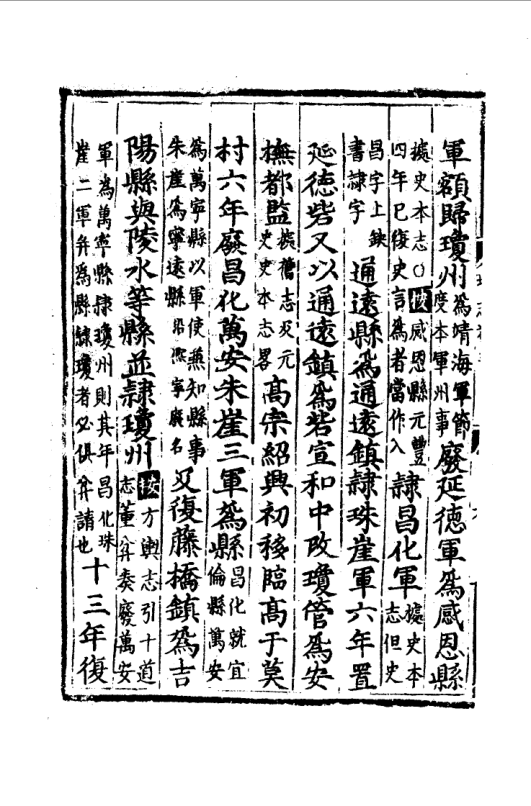

In [8]:
from google.colab import files
from IPython.display import Image, display
import os

# 上传图像
print("Please upload your Capture.PNG file:")
uploaded = files.upload()

# 获取上传后的文件名
image_path = list(uploaded.keys())[0]
print(f"\nUploaded file: {image_path}")

# 显示上传的图像
print("\nPreview of uploaded image:")
display(Image(filename=image_path))

In [9]:
import os
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/DeepSeek-OCR


In [10]:
# 使用指定 CUDA 版本重新安装 flash-attention
# 可通过 !nvidia-smi 查看 CUDA 版本，并按需调整 cu121
!pip install flash-attn==2.7.3 --no-build-isolation --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


## 5. 加载 DeepSeek-OCR 模型

此步骤将从 HuggingFace 下载模型（可能需要几分钟）。

In [11]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

# 确认当前工作目录正确
%cd /content/drive/MyDrive/DeepSeekOCR

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 将 attn_implementation='flash_attention_2' 移除，作为排查步骤
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

Loading DeepSeek-OCR model...
This may take several minutes on first run...

/content/drive/MyDrive/DeepSeekOCR


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


In [12]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model...")
print("This may take several minutes on first run...\n")

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 将 attn_implementation='flash_attention_2' 移除，作为排查步骤
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

Loading DeepSeek-OCR model...
This may take several minutes on first run...



You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model dtype: torch.bfloat16


## 6. 运行 OCR 推理

Running OCR inference using model.infer...

Original working directory: /content/drive/MyDrive/DeepSeekOCR
Changed working directory to: /content
Please upload your image for OCR:


Saving page_18.png to page_18.png

Uploaded file: page_18.png
Image path for inference: /content/page_18.png

Preview of uploaded image:


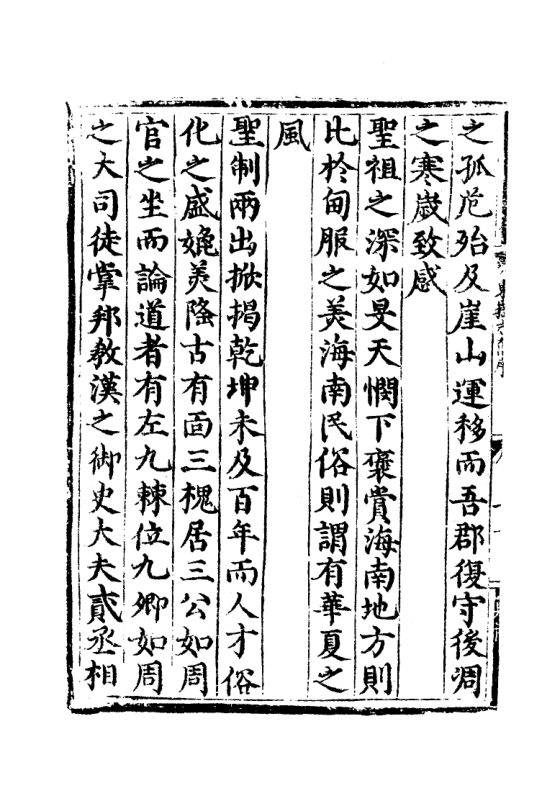

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Changed working directory back to: /content/drive/MyDrive/DeepSeekOCR
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[150, 135, 900, 870]]<|/det|>
之孤危殆及崖山運移而吾郡復守後凋
之寒歲致感
聖祖之深如昊天憫下褒賞海南地方則
比於甸服之美海南民俗則謂有華夏之
風
聖制兩出掀揭乾坤未及百年而人才俗
化之盛媲美隆古有面三槐居三公如周
官之坐而論道者有左九棘位九卿如周
之大司徒掌邦教漢之御史大夫貳丞相
image size:  (542, 806)
valid image tokens:  772
output texts tokens (valid):  132
compression ratio:  0.17
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 1/1 [00:00<00:00, 14074.85it/s]

Inference completed in 29.87 seconds

OCR RESULT:
None


In [17]:
from PIL import Image
import time
import os
import torch
from google.colab import files
from IPython.display import Image, display

print("Running OCR inference using model.infer...\n")
start_time = time.time()

# 保存当前工作目录
original_cwd = os.getcwd()
print(f"Original working directory: {original_cwd}")

# 临时将工作目录切换到 /content 以便上传文件
try:
    os.chdir('/content')
    print(f"Changed working directory to: {os.getcwd()}")

    # 上传图像
    print("Please upload your image for OCR:")
    uploaded = files.upload()
    # 获取上传后的文件名
    uploaded_filename = list(uploaded.keys())[0]
    # 图像会上传到当前工作目录，此时为 /content
    image_path = os.path.join(os.getcwd(), uploaded_filename)
    print(f"\nUploaded file: {uploaded_filename}")
    print(f"Image path for inference: {image_path}")

    # 显示上传的图像
    print("\nPreview of uploaded image:")
    display(Image(filename=image_path))

finally:
    # 将工作目录切回原位置
    os.chdir(original_cwd)
    print(f"Changed working directory back to: {os.getcwd()}")

# 定义提示词和输出目录
# prompt = "<image>\nFree OCR. "
prompt = "<image>\n<|grounding|>Convert the document to markdown. "
base_output_dir = '/content/drive/MyDrive/DeepSeekOCR/ocr_output'

# 若输出目录不存在则创建
os.makedirs(base_output_dir, exist_ok=True)

def prepare_unique_output_dir(base_dir, prefix="run_"):
    # 为每次推理创建独立目录，防止覆盖旧结果
    index = 1
    while True:
        candidate = os.path.join(base_dir, f"{prefix}{index}")
        if not os.path.exists(candidate):
            os.makedirs(candidate)
            return candidate
        index += 1

output_path = prepare_unique_output_dir(base_output_dir)
latest_single_output_dir = output_path
print(f"Results will be saved to: {output_path}")

# 调用 infer 方法执行推理
with torch.no_grad():
    # infer(self, tokenizer, prompt='', image_file='', output_path = ' ', base_size = 1024, image_size = 640, crop_mode = True, test_compress = False, save_results = False):

    # Tiny：base_size = 512，image_size = 512，crop_mode = False
    # Small：base_size = 640，image_size = 640，crop_mode = False
    # Base：base_size = 1024，image_size = 1024，crop_mode = False
    # Large：base_size = 1280，image_size = 1280，crop_mode = False

    # Gundam：base_size = 1024，image_size = 640，crop_mode = True

    res = model.infer(
        tokenizer,
        prompt=prompt,  # 控制输出格式
        image_file=image_path,  # 使用 /content 下的完整路径
        output_path=output_path,
        base_size=1024,
        image_size=640,
        crop_mode=True,
        save_results=True,
        test_compress=True,
    )

end_time = time.time()

print(f"Inference completed in {end_time - start_time:.2f} seconds\n")
print("=" * 80)
print("OCR RESULT:")
print("=" * 80)
# infer 方法的返回格式可能不同，
# 这里假设可以直接获取文本或易于访问的结构。
# 可根据 model.infer 的实际输出格式进行调整
print(res)
print("=" * 80)

# 注意：当 save_results=True 时，infer 会将结果保存到 output_path
# 可能需要在下一个单元中调整保存与下载逻辑
# 具体取决于 model.infer 的保存方式。

# 运行此单元以及读取输出文件的单元后，可以使用
# 单元 1c499536 中的 display_image_and_text 函数对比图像与识别文本。
# 示例：display_image_and_text(image_path, ocr_text_from_file)


In [ ]:
import os
from pathlib import Path

# 检查保存的 OCR 结果输出目录
base_output_dir = Path('/content/drive/MyDrive/DeepSeekOCR/ocr_output')

print(f"Checking saved runs under: {base_output_dir}")

if base_output_dir.exists():
    run_dirs = sorted(
        (d for d in base_output_dir.iterdir() if d.is_dir()),
        key=lambda p: p.stat().st_mtime
    )
    if not run_dirs:
        print("No run directories found yet.")
    for run_dir in run_dirs:
        mmd_files = sorted(run_dir.glob('*.mmd'))
        if not mmd_files:
            print(f"\n{run_dir.name}: no .mmd files found.")
            continue
        for mmd_file in mmd_files:
            print(f"\nReading content from: {mmd_file}\n")
            with mmd_file.open('r', encoding='utf-8') as f:
                ocr_text = f.read()
                print("=" * 80)
                print(f"OCR RESULT ({run_dir.name}/{mmd_file.name}):")
                print("=" * 80)
                print(ocr_text)
                print("=" * 80)
else:
    print("\nOutput directory does not exist.")

Checking the output directory: /content/drive/MyDrive/DeepSeekOCR/ocr_output
Files found in /content/drive/MyDrive/DeepSeekOCR/ocr_output: ['images', 'result.mmd', 'result_with_boxes.jpg']

Reading content from: /content/drive/MyDrive/DeepSeekOCR/ocr_output/result.mmd

SAVED OCR RESULT:

恩縣屬崖州
用知州
詳
請
正
統
五
年
皆
三
州
附
郭
宜 


僞萬寧寧遠三縣
程
用
知
府
請
今
領
州
三
縣
十 


環山縣附郭本漢朱崖縣璘賜地隋於其東境
置顏盧縣 


資五年 


復置縣 


唐武德初於顏盧置崖州 


開宋
州
熙
寧
四
年
省
唐
武
德
初
於
顏
盧
置
崖
州
開
宋 


年廢
貞觀五年
始於崖州之環山地置環州倚 


郭置環山縣十三年析置曾口今
南境
顏羅容 


環今樂三縣俱乾封後設山崗蠻貞元間李復討復元至元間 


乾封後陷山崗蠻貞元間李復討復元至元


## 8. 批量处理（可选）

一次处理多张图像。

In [ ]:
from PIL import Image
import time
import os
import torch
from google.colab import files
from IPython.display import Image, display

# 上传多张图像
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}

base_output_dir = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output'

os.makedirs(base_output_dir, exist_ok=True)

def prepare_unique_output_dir(base_dir, prefix="run_"):
    # 为每次批处理创建独立目录，防止覆盖旧结果
    index = 1
    while True:
        candidate = os.path.join(base_dir, f"{prefix}{index}")
        if not os.path.exists(candidate):
            os.makedirs(candidate)
            return candidate
        index += 1

output_path = prepare_unique_output_dir(base_output_dir)
latest_batch_output_dir = output_path
print(f"Batch results will be saved to: {output_path}")

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # 在当前工作目录中拼接完整的图像路径
        image_path = os.path.join(os.getcwd(), filename)

        # 定义提示词（根据 DeepSeek-OCR 的输入格式调整）
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # 调用 infer 方法进行批量处理
            res = model.infer(
                tokenizer,
                prompt=prompt,
                image_file=image_path,  # 使用上传后的图像路径
                output_path=output_path,
                base_size=1024,
                image_size=640,
                crop_mode=True,
                save_results=True,
                test_compress=True,
            )

            # 当 save_results=True 时，infer 会将结果写入 output_path
            # 可按需调整如何读取或确认保存结果
            # 在本示例中仅记录任务已完成
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"✓ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"✗ Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# 显示全部结果（或处理完成的提示）
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# 注意：若需一次性下载批量结果，可能需要
# 将输出目录打包或遍历保存的文件。
# 由于 model.infer 已负责保存，此处保持注释。
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')


Upload multiple images for batch processing:


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saving page_168.png to page_168.png
Saving page_169.png to page_169.png

Processing page_168.png...
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[666, 163, 840, 830]]<|/det|>
書之如南郡之湄巫廬江之黃穰是也若因
敘幸於其傳而遽疑爲外之於夷則南郡廬 

<|ref|>text<|/ref|><|det|>[[580, 163, 675, 830]]<|/det|>
江之在當時亦未郡縣乎此皆不通之論也 

<|ref|>text<|/ref|><|det|>[[494, 163, 592, 830]]<|/det|>
桐鄉又罪陳壽義烏討朱崖之說以啓晋史 

<|ref|>text<|/ref|><|det|>[[402, 163, 500, 830]]<|/det|>
之傳信外紀三萬兵非數十艘船不能濟物
造又不書渡海否到朱崖勝負得實妄 

<|ref|>text<|/ref|><|det|>[[310, 163, 410, 830]]<|/det|>
將虛言有如兒戲致悵晉書合爲一說鄙壽
偏方薄行言不足信夫壽在當時稱爲良史 

<|ref|>text<|/ref|><|det|>[[220, 163, 320, 830]]<|/det|>
數其事以責其人固所難免若因以蓋其人 

<|ref|>text<|/ref|><|det|>[[78, 163, 230, 830]]<|/det|>
而遂盡廢其書則三國數十年之事天下後
image size:  (531, 806)
valid image tokens:  768
output texts tokens (valid):  296
compression ratio:  0.39
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 7/7 [00:00<00:00, 87122.04it/s]

✓ page_168.png processed successfully. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output

Processing page_169.png...



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[770, 202, 915, 872]]<|/det|>
世將俱無所賴乎且東漢珠崖之縣先紀於
范書聞風慕義貢獻之說俗沿於土志亦皆 

<|ref|>text<|/ref|><|det|>[[675, 202, 777, 872]]<|/det|>
壽啓之歎曰子之言辯矣安知穆之博學不 

<|ref|>text<|/ref|><|det|>[[583, 202, 682, 872]]<|/det|>
無所據而云然也曰書之可信者經外莫要 

<|ref|>text<|/ref|><|det|>[[491, 202, 592, 872]]<|/det|>
於史今穆之說皆史之所無則雖有據亦未 

<|ref|>text<|/ref|><|det|>[[399, 202, 500, 872]]<|/det|>
敢以爲然也且後先乎穆者不有東坡深庵 

<|ref|>text<|/ref|><|det|>[[307, 202, 410, 872]]<|/det|>
氏乎其記伏泱廟曰若非新息苦戰之功則 

<|ref|>text<|/ref|><|det|>[[215, 202, 319, 472]]<|/det|>
九郡郡言九則珠崖九郡傳耳在内可知 

<|ref|>text<|/ref|><|det|>[[125, 202, 225, 872]]<|/det|>
史定交部始調立城郭置井邑之說其賦奇
image size:  (531, 806)
valid image tokens:  768
output texts tokens (valid):  298
compression ratio:  0.39
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 8/8 [00:00<00:00, 68618.47it/s]

✓ page_169.png processed successfully. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output

BATCH PROCESSING SUMMARY

--- page_168.png ---
Processed. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output


--- page_169.png ---
Processed. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output


Detailed results are saved in the directory: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output


Displaying Single Image and OCR Result:



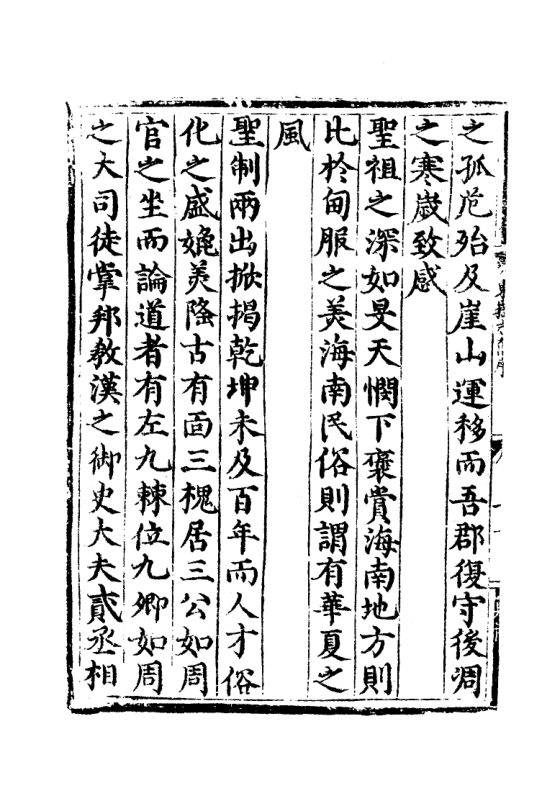


Displaying Last Batch Processed Image and OCR Result:



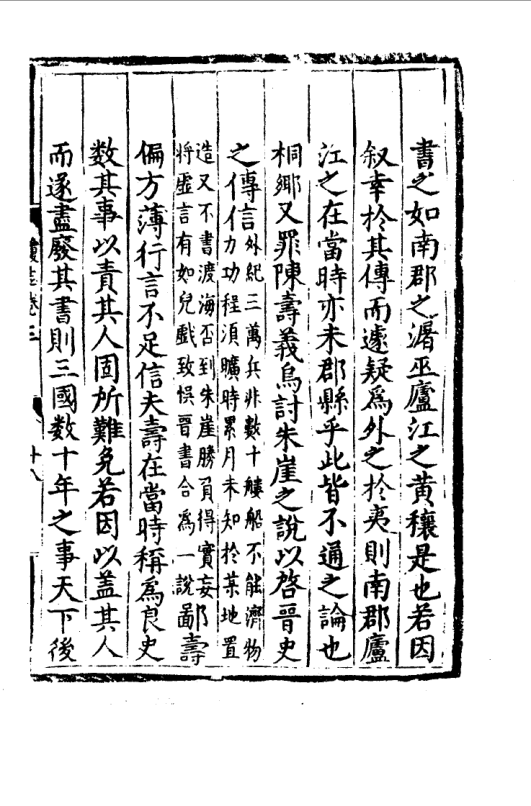

In [ ]:
import os
from pathlib import Path
from IPython.display import display, HTML, Image

def display_image_and_text(image_path, ocr_text):
    # 显示图片和OCR文本结果
    try:
        from base64 import b64encode
        with open(image_path, 'rb') as f:
            image_bytes = f.read()
        image_base64 = b64encode(image_bytes).decode('utf-8')
        image_tag = f'<img src="data:image/png;base64,{image_base64}" style="max-width: 100%; height: auto;">'
    except Exception as e:
        image_tag = f"Could not load image: {e}"
        print(f"Error loading image {image_path}: {e}")

    html_content = f'''
    <div style="display: flex; gap: 20px;">
        <div style="flex: 1;">
            <h3>Original Image</h3>
            {image_tag}
        </div>
        <div style="flex: 1; overflow-y: auto; max-height: 600px; border: 1px solid #ccc; padding: 10px;">
            <h3>OCR Text</h3>
            <pre style="white-space: pre-wrap; word-wrap: break-word;">{ocr_text}</pre>
        </div>
    </div>
    '''
    display(HTML(html_content))

def latest_run_dir(base_dir, fallback=None):
    # 获取最新的运行目录，用于显示 HTML 结果
    if fallback and fallback.exists():
        return fallback
    if not base_dir.exists():
        return None
    run_dirs = sorted(
        (d for d in base_dir.iterdir() if d.is_dir()),
        key=lambda p: p.stat().st_mtime,
        reverse=True
    )
    return run_dirs[0] if run_dirs else None

# --- 显示单张图片的处理结果 ---
# 将 'path/to/your/image.png' 替换为实际图片路径
# 将 'Your OCR text here' 替换为实际 OCR 识别结果

single_base_dir = Path('/content/drive/MyDrive/DeepSeekOCR/ocr_output')
latest_single_dir = latest_run_dir(single_base_dir, Path(latest_single_output_dir) if 'latest_single_output_dir' in globals() else None)

single_image_path = image_path if 'image_path' in globals() else None
single_ocr_text = "Could not locate OCR text file."

if latest_single_dir:
    single_mmd_files = sorted(latest_single_dir.glob('*.mmd'))
    if single_mmd_files:
        try:
            with single_mmd_files[0].open('r', encoding='utf-8') as f:
                single_ocr_text = f.read()
        except Exception as e:
            single_ocr_text = f"Error reading OCR text file: {e}"
            print(f"Error reading {single_mmd_files[0]}: {e}")
        if single_image_path is None:
            for pattern in ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.webp'):
                images = list(latest_single_dir.glob(pattern))
                if images:
                    single_image_path = str(images[0])
                    break
else:
    print("No single-image results found.")

if single_image_path:
    print("Displaying Single Image and OCR Result:")
    display_image_and_text(single_image_path, single_ocr_text)
else:
    print("Single image path is unavailable for display.")

# 这是为了处理批量图片的情况，比如 page_150.png
# 这段代码会查找最新的批处理目录
# 并尝试从该目录下的 result.mmd 文件中读取识别结果
# 如果找到了图片和对应的识别结果，就会显示它们

batch_base_dir = Path('/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output')
latest_batch_dir = latest_run_dir(batch_base_dir, Path(latest_batch_output_dir) if 'latest_batch_output_dir' in globals() else None)

batch_ocr_text = "Could not locate batch OCR text file."
batch_mmd_file = None

if latest_batch_dir:
    mmd_files = sorted(latest_batch_dir.glob('*.mmd'))
    if mmd_files:
        batch_mmd_file = mmd_files[0]
        try:
            with batch_mmd_file.open('r', encoding='utf-8') as f:
                batch_ocr_text = f.read()
        except Exception as e:
            batch_ocr_text = f"Error reading batch OCR text file: {e}"
            print(f"Error reading {batch_mmd_file}: {e}")
else:
    print("No batch results found.")

batch_image_path = None
if 'uploaded_files' in globals() and uploaded_files:
    batch_image_filename = list(uploaded_files.keys())[0]
    batch_image_path = os.path.join(os.getcwd(), batch_image_filename)
elif latest_batch_dir:
    for pattern in ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.webp'):
        images = list(latest_batch_dir.glob(pattern))
        if images:
            batch_image_path = str(images[0])
            break

if batch_image_path:
    print("\nDisplaying Last Batch Processed Image and OCR Result:")
    display_image_and_text(batch_image_path, batch_ocr_text)
else:
    print("\nNo batch processed image found to display.")

In [19]:
import os
from pathlib import Path

base_output_dir = Path('/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output')

print(f"Checking the batch output directory tree: {base_output_dir}")

if base_output_dir.exists():
    run_dirs = sorted(
        (d for d in base_output_dir.iterdir() if d.is_dir()),
        key=lambda p: p.stat().st_mtime
    )
    if not run_dirs:
        print("No batch run directories found yet.")
    for run_dir in run_dirs:
        print(f"\nRun directory: {run_dir}")
        files_in_run = list(run_dir.iterdir())
        print(f"Contents: {[f.name for f in files_in_run]}")
        for file_path in files_in_run:
            if file_path.suffix == '.mmd':
                print(f"\nReading content from: {file_path}\n")
                with file_path.open('r', encoding='utf-8') as f:
                    ocr_text = f.read()
                    print("=" * 80)
                    print(f"BATCH OCR RESULT ({run_dir.name}/{file_path.name}):")
                    print("=" * 80)
                    print(ocr_text)
                    print("=" * 80)
else:
    print("\nBatch output directory does not exist.")

Checking the batch output directory: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output
Files found in /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output: ['images', 'result.mmd', 'result_with_boxes.jpg']

Reading content from: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output/result.mmd

BATCH OCR RESULT (result.mmd):

世將俱無所賴乎且東漢珠崖之縣先紀於
范書聞風慕義貢獻之說俗沿於土志亦皆 


壽啓之歎曰子之言辯矣安知穆之博學不 


無所據而云然也曰書之可信者經外莫要 


於史今穆之說皆史之所無則雖有據亦未 


敢以爲然也且後先乎穆者不有東坡深庵 


氏乎其記伏泱廟曰若非新息苦戰之功則 


九郡郡言九則珠崖九郡傳耳在内可知 


史定交部始調立城郭置井邑之說其賦奇


In [ ]:
from PIL import Image
import time
import os
import torch

# 上传多个图像进行批处理
print("Upload multiple images for batch processing:")
uploaded_files = files.upload()

results = {}

base_output_dir = '/content/drive/MyDrive/DeepSeekOCR/batch_ocr_output2'

os.makedirs(base_output_dir, exist_ok=True)

def prepare_unique_output_dir(base_dir, prefix="run_"):
    # 为每次批处理创建独立目录，防止覆盖旧结果
    index = 1
    while True:
        candidate = os.path.join(base_dir, f"{prefix}{index}")
        if not os.path.exists(candidate):
            os.makedirs(candidate)
            return candidate
        index += 1

output_path = prepare_unique_output_dir(base_output_dir)
latest_batch_output_dir = output_path
print(f"Batch results will be saved to: {output_path}")

for filename in uploaded_files.keys():
    print(f"\nProcessing {filename}...")

    try:
        # 获取当前图像的完整路径
        image_path = os.path.join(os.getcwd(), filename)

        # 设置 DeepSeek-OCR 的识别提示语
        prompt = "<image>\n<|grounding|>Convert the document to markdown. "

        with torch.no_grad():
            # 执行推理处理
            res = model.infer(tokenizer,
                              prompt=prompt,
                              image_file=image_path,  # 使用上传图片的路径
                              output_path=output_path,
                              base_size=1024,
                              image_size=640,
                              crop_mode=True,
                              save_results=True,
                              test_compress=True)

            # 当 save_results=True 时，infer 会将结果保存到 output_path
            # 记录处理结果状态
            # 记录处理成功信息
            results[filename] = f"Processed. Output saved to {output_path}"
            print(f"√ {filename} processed successfully. Output saved to {output_path}")

    except Exception as e:
        print(f"× Error processing {filename}: {str(e)}")
        results[filename] = f"Error: {str(e)}"

# 显示批处理的汇总结果
print("\n" + "=" * 80)
print("BATCH PROCESSING SUMMARY")
print("=" * 80)

for filename, result in results.items():
    print(f"\n--- {filename} ---")
    print(result)
    print()

print(f"\nDetailed results are saved in the directory: {output_path}")

# 注意：如果需要下载所有结果
# 可以将结果打包或者生成汇总文件
# 根据 model.infer 的具体输出格式调整
# with open('batch_results.txt', 'w', encoding='utf-8') as f:
#     for filename, result in results.items():
#         f.write(f"{'='*80}\n")
#         f.write(f"File: {filename}\n")
#         f.write(f"{'='*80}\n")
#         f.write(result)
#         f.write(f"\n\n")
#
# files.download('batch_results.txt')

Upload multiple images for batch processing:


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Saving page_24.png to page_24.png

Processing page_24.png...
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>text<|/ref|><|det|>[[679, 191, 844, 840]]<|/det|>
者然所注不拘顯晦惟以先統後非惟例史之序諸傳蓋欲微存古重姓氏立簿狀之義 

<|ref|>text<|/ref|><|det|>[[588, 191, 690, 840]]<|/det|>
以示先王宗法於一方惜孤陋不能盡知尔 

<|ref|>text<|/ref|><|det|>[[504, 191, 608, 840]]<|/det|>
一文字惟貴事理純當故有全取有節取間有
不取者亦必注某人文見碑或見舊志而不 

<|ref|>text<|/ref|><|det|>[[411, 191, 512, 840]]<|/det|>
敢盡掩其跡 

<|ref|>text<|/ref|><|det|>[[269, 170, 420, 840]]<|/det|>
一叙名宦流寓等賢有休史本傳或綱目全文
者有節取者或舊志已載而酌定者惟欲事 

<|ref|>text<|/ref|><|det|>[[125, 191, 280, 840]]<|/det|>
跡之切於郡尔間有事言千郡而不係出處
image size:  (554, 818)
valid image tokens:  773
output texts tokens (valid):  247
compression ratio:  0.32
===============save results:===============


image: 0it [00:00, ?it/s]
other: 100%|██████████| 6/6 [00:00<00:00, 80145.94it/s]

✓ page_24.png processed successfully. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output2

BATCH PROCESSING SUMMARY

--- page_24.png ---
Processed. Output saved to /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output2


Detailed results are saved in the directory: /content/drive/MyDrive/DeepSeekOCR/batch_ocr_output2


In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import os

print("Loading DeepSeek-OCR model for batch processing...")

# 确认当前工作目录正确
%cd /content/drive/MyDrive/DeepSeekOCR

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
model_name = 'deepseek-ai/DeepSeek-OCR'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# 将 attn_implementation='flash_attention_2' 移除，作为排查步骤
model = AutoModel.from_pretrained(model_name, trust_remote_code=True, use_safetensors=True)
model = model.eval().cuda().to(torch.bfloat16)

print("Model loaded successfully for batch processing!")

## 故障排查

### 常见问题：

1. **内存不足（OOM）：**
   - 使用更高等级的 GPU（A100、V100）
   - 在处理前降低图像分辨率
   - 启用梯度检查点

2. **Flash Attention 安装失败：**
   - 尝试移除 `attn_implementation='flash_attention_2'` 参数
   - 回退到标准注意力机制

3. **模型下载很慢：**
   - 对于大模型这是正常情况（可能需要 10-15 分钟）
   - 首次下载后模型会被缓存

4. **图像格式问题：**
   - 确保图像为 RGB 格式
   - 转换示例：`img = img.convert('RGB')`

### 性能优化建议：

- 使用接近模型默认分辨率的图片：512×512、640×640、1024×1024、1280×1280
- 如需更快推理，使用 `torch.float16`（已默认启用）
- 对多张图片，批量处理更高效

## 清理（可选）

完成后释放 GPU 内存。

In [ ]:
# 清空 GPU 内存
import gc

del model
del tokenizer
gc.collect()
torch.cuda.empty_cache()

print("GPU memory cleared")